In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
include("TimeMarching.jl")
include("Tool.jl")
include("Initial.jl")

initial_sod (generic function with 1 method)

## Initialization

In [3]:
    # Initial spacial variables
    nx = 201   
    gamma = 1.4
    xlim = (0.0,1.0)
    Δx = (xlim[2]-xlim[1])/nx
    ux,uu=initial_sod(nx,xlim,gamma)
    
    # Initial time and storage arrays
    t = 0.0
    thist = []
    uhist = []


0-element Array{Any,1}

In [4]:
#     #get sound speed and CFL
#     cc = uutourhoc(uu,gamma)[3,:]
#     Δx = (xlim[end]-xlim[1])/nx
#     cfl = Δt*maximum(cc)/(Δx)

## Time Marching

In [5]:
    Δt = 0.001

    println("Δx=",Δx);
    println("Δt=",Δt);
    
    #Calculation time
    tf = 1
    tsample = Δt
    T = Δt:Δt:tf

    # Push it with time!
    for ti in T
         t, uu = stegerwarmingrk1!(t,uu)
    
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(thist,deepcopy(t)) : nothing
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,deepcopy(uutourhop(uu,gamma))) : nothing
    end
    

Δx=0.004975124378109453
Δt=0.001


## Plotting

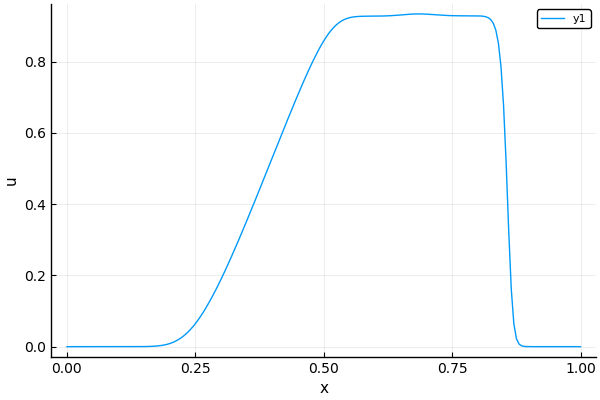

In [9]:
plt = plot(ylabel = "\$y\$", 
    xlabel = "Convective Time")
plot!(ux,uhist[200][1,:], legend = true, xlabel="x", ylabel="u", xtickfont=10, ytickfont=10)
plt

